In [1]:
import gc
import dill
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from pprint import pprint
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
pd.options.display.float_format = "{:,.2f}".format

# the following imports are from network / axl_utils folder
import network
from axl_utils.nnplayer import NNplayer, State
from axl_utils.game import *

In [2]:
C = axl.Action.C
D = axl.Action.D

# config game rules
# doubled game length for some extra complexity
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

In [3]:
# import my modified tournament
# which ignores the interaction in last turn
from axl_utils.tournament import Tournament

### this stage will use axl.tournament function to train DQN play against multiple strategies

In [4]:
tournament = Tournament([axl.Defector(), axl.Cooperator()], game=GAME, turns=GAME_LEN)
results = tournament.play()

Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 108.22it/s]


In [5]:
# example tournament result
# explanation of the elements can be found here: https://axelrod.readthedocs.io/en/stable/tutorials/advanced/tournament_results.html
summary = results.summarise()
headers = "Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate".split(',')
pd.DataFrame(map(list, summary), columns=headers)

# median score is based on normalized score, which represent the average return for each turn
# e.g. if 2 player cooperates the whole game, this should be 3.00 for both

,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,Defector,5.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0,0.00,0,0
1,1,Cooperator,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0,1.00,0,0


In [6]:
# this is the environment we'll be using

# I'm trying to encourage provocative defection     (against cooperative)
# and retaliative defection                         (against provocative)
# while at the same time punish excessive defection (against retaliative)


# documentation of the strategies can be found here
# https://axelrod.readthedocs.io/en/stable/_modules/index.html

cooperative = (axl.Cooperator(), axl.TitFor2Tats())
provocative = (axl.Prober(), axl.Prober4(), axl.RemorsefulProber())
retaliative = (axl.TitForTat(), axl.Grudger(), axl.Punisher())
noise       = ()  #(axl.Random(), axl.Alternator())

players = [*cooperative, *provocative, *retaliative, *noise]
tournament = Tournament(players, game=GAME, turns=GAME_LEN)
results = tournament.play()

summary = results.summarise()
pd.DataFrame(map(list, summary), columns=headers)

Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 109.18it/s]


,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,Tit For Tat,2.83,0.90,0.00,1.00,0.80,0.09,0.08,0.02,1.00,0.00,1.00,0.00
1,1,Remorseful Prober: 0.1,2.64,0.69,3.00,1.00,0.56,0.13,0.15,0.16,0.91,0.00,0.91,0.80
2,2,Grudger,2.61,0.68,2.00,1.00,0.66,0.02,0.08,0.24,1.00,0.00,0.00,0.00
3,3,Punisher,2.56,0.66,2.00,1.00,0.64,0.02,0.08,0.26,1.00,0.00,0.00,0.00
4,4,Tit For 2 Tats,2.50,0.87,0.00,1.00,0.77,0.10,0.02,0.12,1.00,0.79,1.00,0.00
5,5,Prober 4,2.40,0.50,4.00,1.00,0.24,0.26,0.30,0.20,0.34,0.35,0.76,0.70
6,6,Prober,2.39,0.37,2.00,0.00,0.25,0.12,0.26,0.37,0.80,0.55,0.77,0.00
7,7,Cooperator,2.37,1.00,0.00,1.00,0.79,0.21,0.00,0.00,1.00,1.00,0.00,0.00


In [7]:
# DQN as usual
# + a bit more complex architecture
dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 300),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(300, 150),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(150, 80),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(80, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ],
            network.ReplayMemory(8000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 3e-6, 'batch': 128, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-2), "loss_fn":"mse"}

In [8]:
from random import shuffle     

# function to match the DQN against a list of opponents
def train_against(player, opponents, iterations=40):
    for _  in range(iterations):
        shuffle(opponents)
        for opponent in opponents:
            play(player, opponent, show=False)

In [9]:
train_against(p1, players)
len(p1.network.memory)      # 21(turns) * 8(# of opponents) * 40(iterations)

6720

## Training loop
**takes ~ 4 hours to run**

In [10]:
# time to take a nap
ls = []
loss_ls = []
epoch_ls = []
for i in range(100):
    
    start = time()
    p1.train(200, param)
    
    train_against(p1, players)
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # test DQN in tournament
    if i % 2 == 0:
        loss_ls.append(np.sum(p1.network.loss))
        with p1:
            p1.network.verbosity = False
            tournament = Tournament([p1, *players], game=GAME, turns=GAME_LEN)
            results = tournament.play()
            summary = pd.DataFrame(map(list, results.summarise()), columns=headers).set_index('Name')
            ls.append(summary)
            epoch_ls.append(p1.network.loss_ls[-1][0])
            
        print(summary.loc['DQN', ['Rank', 'Median_score']])
        
        # backing up
        with open('data/s2/tn_results.pkl', "wb") as file:
            dill.dump(ls, file)

        with open(f'data/s2/p1_{i}.pkl', "wb") as file:
            dill.dump(p1, file)

loss: [0.592 0.866],            time: +127.34 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 128.84it/s]


Rank           8.00
Median_score   1.99
Name: DQN, dtype: float64
loss: [0.6   0.804],            time: +145.19 sec
loss: [0.677 1.002],            time: +146.32 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 98.80it/s]


Rank           7.00
Median_score   2.25
Name: DQN, dtype: float64
loss: [0.777 1.   ],            time: +131.05 sec
loss: [0.818 0.805],            time: +115.55 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 156.18it/s]


Rank           6.00
Median_score   2.38
Name: DQN, dtype: float64
loss: [0.826 0.954],            time: +116.26 sec
loss: [0.677 1.104],            time: +110.24 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 161.26it/s]


Rank           4.00
Median_score   2.43
Name: DQN, dtype: float64
loss: [1.331 0.836],            time: +109.70 sec
loss: [1.109 1.127],            time: +111.54 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 153.33it/s]


Rank           2.00
Median_score   2.56
Name: DQN, dtype: float64
loss: [0.865 0.949],            time: +110.41 sec
loss: [1.105 0.914],            time: +111.97 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 152.44it/s]


Rank           5.00
Median_score   2.42
Name: DQN, dtype: float64
loss: [1.234 1.003],            time: +112.90 sec
loss: [1.371 0.844],            time: +109.61 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 150.60it/s]


Rank           5.00
Median_score   2.33
Name: DQN, dtype: float64
loss: [0.911 1.149],            time: +115.92 sec
loss: [0.925 1.275],            time: +110.16 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 130.91it/s]


Rank           7.00
Median_score   2.33
Name: DQN, dtype: float64
loss: [0.987 1.099],            time: +112.32 sec
loss: [0.971 1.323],            time: +110.42 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 158.23it/s]


Rank           1.00
Median_score   2.57
Name: DQN, dtype: float64
loss: [0.837 1.279],            time: +110.34 sec
loss: [1.342 1.108],            time: +109.92 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 168.91it/s]


Rank           1.00
Median_score   2.64
Name: DQN, dtype: float64
loss: [0.9   1.504],            time: +111.06 sec
loss: [0.857 1.574],            time: +108.71 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 151.52it/s]


Rank           1.00
Median_score   2.70
Name: DQN, dtype: float64
loss: [0.977 0.931],            time: +110.28 sec
loss: [1.255 0.896],            time: +116.74 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 149.67it/s]


Rank           1.00
Median_score   2.62
Name: DQN, dtype: float64
loss: [1.168 0.988],            time: +112.14 sec
loss: [1.067 1.014],            time: +111.51 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 129.54it/s]


Rank           1.00
Median_score   2.65
Name: DQN, dtype: float64
loss: [0.866 1.276],            time: +111.12 sec
loss: [1.152 0.929],            time: +109.83 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 157.23it/s]


Rank           1.00
Median_score   2.55
Name: DQN, dtype: float64
loss: [1.073 1.151],            time: +113.41 sec
loss: [1.285 0.97 ],            time: +108.52 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 153.35it/s]


Rank           1.00
Median_score   2.75
Name: DQN, dtype: float64
loss: [1.153 0.808],            time: +114.62 sec
loss: [0.852 1.185],            time: +113.28 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 149.70it/s]


Rank           1.00
Median_score   2.65
Name: DQN, dtype: float64
loss: [0.951 1.169],            time: +111.89 sec
loss: [0.852 1.281],            time: +113.59 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 141.24it/s]


Rank           1.00
Median_score   2.73
Name: DQN, dtype: float64
loss: [1.124 0.771],            time: +113.07 sec
loss: [1.244 0.868],            time: +111.51 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 136.25it/s]


Rank           0.00
Median_score   2.86
Name: DQN, dtype: float64
loss: [0.988 0.854],            time: +113.93 sec
loss: [1.245 1.117],            time: +112.44 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 154.35it/s]


Rank           1.00
Median_score   2.69
Name: DQN, dtype: float64
loss: [1.19  0.968],            time: +116.15 sec
loss: [1.061 0.972],            time: +114.33 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 155.25it/s]


Rank           1.00
Median_score   2.68
Name: DQN, dtype: float64
loss: [1.065 1.146],            time: +112.03 sec
loss: [1.283 0.962],            time: +110.91 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 159.21it/s]


Rank           2.00
Median_score   2.66
Name: DQN, dtype: float64
loss: [1.115 0.94 ],            time: +113.98 sec
loss: [1.216 0.896],            time: +109.54 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 149.63it/s]


Rank           1.00
Median_score   2.71
Name: DQN, dtype: float64
loss: [1.191 0.993],            time: +113.30 sec
loss: [1.106 1.034],            time: +108.84 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 138.12it/s]


Rank           1.00
Median_score   2.69
Name: DQN, dtype: float64
loss: [1.174 0.772],            time: +111.82 sec
loss: [1.349 0.839],            time: +110.63 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 164.47it/s]


Rank           1.00
Median_score   2.73
Name: DQN, dtype: float64
loss: [1.241 0.941],            time: +113.43 sec
loss: [1.013 0.999],            time: +110.24 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 160.26it/s]


Rank           1.00
Median_score   2.74
Name: DQN, dtype: float64
loss: [0.917 1.187],            time: +111.47 sec
loss: [1.112 0.962],            time: +111.23 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 182.49it/s]


Rank           1.00
Median_score   2.73
Name: DQN, dtype: float64
loss: [1.386 0.992],            time: +113.29 sec
loss: [1.253 0.83 ],            time: +112.14 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 178.53it/s]


Rank           1.00
Median_score   2.74
Name: DQN, dtype: float64
loss: [1.083 0.736],            time: +114.56 sec
loss: [1.19 0.95],            time: +111.52 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 161.29it/s]


Rank           1.00
Median_score   2.73
Name: DQN, dtype: float64
loss: [1.22 0.92],            time: +111.61 sec
loss: [1.801 0.823],            time: +111.87 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 182.44it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [0.979 1.027],            time: +114.37 sec
loss: [1.118 0.892],            time: +109.40 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 183.79it/s]


Rank           1.00
Median_score   2.74
Name: DQN, dtype: float64
loss: [1.258 0.776],            time: +112.15 sec
loss: [1.411 0.655],            time: +109.03 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 177.95it/s]


Rank           1.00
Median_score   2.64
Name: DQN, dtype: float64
loss: [0.84  1.234],            time: +112.80 sec
loss: [0.799 1.192],            time: +111.54 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 187.86it/s]


Rank           1.00
Median_score   2.80
Name: DQN, dtype: float64
loss: [1.125 0.936],            time: +114.12 sec
loss: [1.258 0.649],            time: +112.39 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 172.38it/s]


Rank           0.00
Median_score   2.85
Name: DQN, dtype: float64
loss: [1.161 0.597],            time: +114.46 sec
loss: [1.063 0.705],            time: +112.62 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 183.82it/s]


Rank           1.00
Median_score   2.69
Name: DQN, dtype: float64
loss: [0.809 1.16 ],            time: +113.80 sec
loss: [1.025 1.15 ],            time: +111.82 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 183.89it/s]


Rank           1.00
Median_score   2.76
Name: DQN, dtype: float64
loss: [0.807 0.984],            time: +112.04 sec
loss: [0.966 0.951],            time: +108.51 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.20it/s]


Rank           1.00
Median_score   2.75
Name: DQN, dtype: float64
loss: [1.02  0.872],            time: +116.24 sec
loss: [1.24  0.847],            time: +109.79 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 161.29it/s]


Rank           1.00
Median_score   2.70
Name: DQN, dtype: float64
loss: [1.007 0.808],            time: +111.89 sec
loss: [1.038 0.868],            time: +111.26 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 181.12it/s]


Rank           1.00
Median_score   2.75
Name: DQN, dtype: float64
loss: [0.968 1.034],            time: +108.95 sec
loss: [1.278 0.874],            time: +111.68 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 170.03it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [0.786 1.122],            time: +113.25 sec
loss: [1.207 0.646],            time: +110.60 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 183.79it/s]


Rank           1.00
Median_score   2.76
Name: DQN, dtype: float64
loss: [0.8   1.023],            time: +115.46 sec
loss: [0.881 1.059],            time: +112.62 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 177.31it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [1.243 0.663],            time: +113.22 sec
loss: [1.028 0.896],            time: +113.24 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 178.59it/s]


Rank           0.00
Median_score   2.85
Name: DQN, dtype: float64
loss: [1.058 0.719],            time: +113.18 sec
loss: [1.035 0.833],            time: +112.35 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 178.53it/s]


Rank           0.00
Median_score   2.83
Name: DQN, dtype: float64
loss: [0.992 0.599],            time: +111.65 sec
loss: [1.343 0.829],            time: +115.87 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 165.53it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [1.136 0.855],            time: +118.58 sec
loss: [1.752 0.597],            time: +117.52 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.62it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [1.542 0.616],            time: +116.59 sec
loss: [1.596 0.501],            time: +111.54 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 174.79it/s]


Rank           0.00
Median_score   2.93
Name: DQN, dtype: float64
loss: [1.143 0.698],            time: +109.00 sec
loss: [1.231 0.579],            time: +109.56 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 170.03it/s]


Rank           0.00
Median_score   2.91
Name: DQN, dtype: float64
loss: [1.091 0.711],            time: +112.96 sec
loss: [1.363 0.709],            time: +109.68 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 183.78it/s]


Rank           0.00
Median_score   2.93
Name: DQN, dtype: float64
loss: [0.877 0.917],            time: +112.83 sec
loss: [0.865 1.352],            time: +112.88 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 182.47it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [1.445 0.74 ],            time: +112.95 sec
loss: [1.057 0.558],            time: +111.31 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 176.06it/s]


Rank           0.00
Median_score   2.88
Name: DQN, dtype: float64
loss: [1.08  0.619],            time: +112.73 sec


## Results

In [12]:
with open("data/s2/backup/tn_results.pkl", "rb") as file:
    ls = dill.load(file)
    
with open("data/s2/backup/p1_98.pkl", "rb") as file:
    p1 = dill.load(file)

In [7]:
pd.DataFrame([l.loc['DQN'] for l in ls], index=range(50))

,Rank,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,8.00,1.99,0.04,8.00,0.00,0.02,0.03,0.24,0.71,0.00,0.00,0.15,0.15
1,7.00,2.25,0.48,5.00,0.00,0.09,0.38,0.36,0.16,0.38,0.48,0.67,0.58
2,6.00,2.38,0.47,5.00,0.00,0.13,0.34,0.36,0.16,0.41,0.22,0.67,0.99
3,4.00,2.43,0.49,4.00,0.00,0.17,0.32,0.35,0.16,0.56,0.37,0.66,0.92
4,2.00,2.56,0.58,4.50,1.00,0.37,0.21,0.26,0.16,0.79,0.30,0.46,0.65
5,5.00,2.42,0.48,6.00,0.00,0.25,0.23,0.29,0.24,0.63,0.30,0.71,0.69
6,5.00,2.33,0.19,6.00,0.00,0.05,0.14,0.34,0.46,0.83,0.31,0.52,0.16
7,7.00,2.33,0.49,4.00,1.00,0.23,0.26,0.28,0.24,0.54,0.28,0.73,0.61
8,1.00,2.57,0.35,6.00,0.00,0.13,0.22,0.38,0.27,0.59,0.36,0.57,0.53
9,1.00,2.64,0.39,5.00,0.00,0.23,0.17,0.34,0.27,0.93,0.42,0.54,0.41


In [16]:
d_score = pd.DataFrame([l.loc['DQN','Median_score'] for l in ls]).to_numpy().T[0]
t_score = pd.DataFrame([l.loc['Tit For Tat','Median_score'] for l in ls]).to_numpy().T[0]

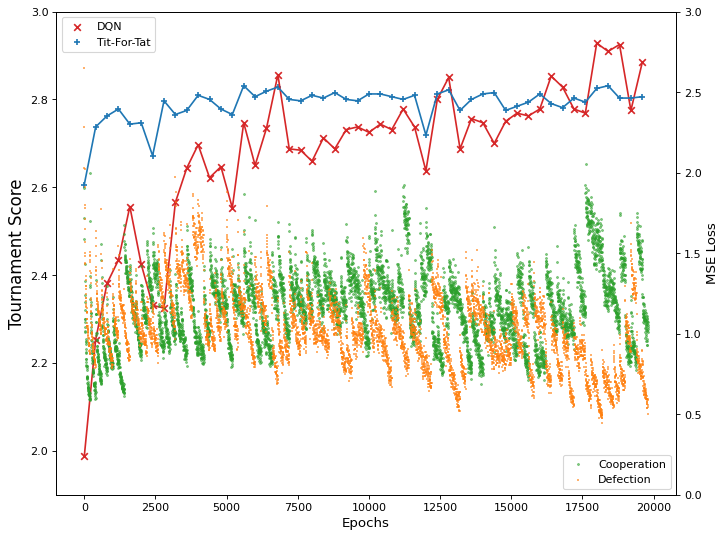

In [147]:
fig, ax1 = plt.subplots(figsize=(10, 8), dpi=80)
ax2 = ax1.twinx()

ax1.scatter(range(0,20000,400), d_score, c='tab:red', marker='x', label='DQN')
ax1.scatter(range(0,20000,400), t_score, c='tab:blue', marker='+', label='Tit-For-Tat')
ax1.plot(range(0,20000,400), d_score, c='tab:red')
ax1.plot(range(0,20000,400), t_score, c='tab:blue')
ax1.set_ylim([1.9, 3.0])

ax2.scatter(*zip(*[(i[0], i[1][0]) for i in p1.network.loss_ls[::3]]), c='tab:green', marker='x', label='Cooperation', alpha=.6, s=3)
ax2.scatter(*zip(*[(i[0], i[1][1]) for i in p1.network.loss_ls[::3]]), c='tab:orange', marker='+', label='Defection', alpha=.6, s=3)
ax2.set_ylim([0.0, 3.0])

ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Tournament Score', fontsize=15)
ax1.legend(loc='upper left')

ax2.set_ylabel('MSE Loss', fontsize=12)
ax2.legend(loc='lower right')

plt.show()

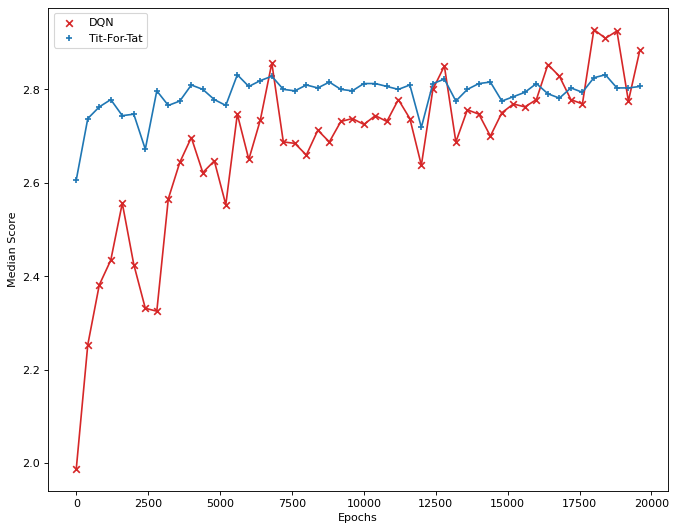

In [148]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(0,20000,400), d_score, c='tab:red', marker='x', label='DQN')
plt.scatter(range(0,20000,400), t_score, c='tab:blue', marker='+', label='Tit-For-Tat')
plt.plot(range(0,20000,400), d_score, c='tab:red')
plt.plot(range(0,20000,400), t_score, c='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Median Score')
plt.legend(loc='upper left')
plt.show()

In [39]:
p1.set_greedy(0)
p1.network.verbosity = False

In [40]:
print("Prober")
play(p1, axl.RemorsefulProber(0.2));

print("\nTFT")
play(p1, axl.TitForTat());

print("\nAlternator")
play(p1, axl.Alternator());

Prober
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0), (0, 5), (0, 5), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (0, 5), (5, 0), (0, 5), (5, 0)]
Player 1 score = 54
Player 2 score = 59

TFT
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0), (0, 5), (3, 3), (3, 3), (5, 0), (0, 5), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 60
Player 2 score = 55

Alternator
[(3, 3), (0, 5), (5, 0), (0, 5), (3, 3), (0, 5), (3, 3), (1, 1), (3, 3), (1, 1), (3, 3), (0, 5), (5, 0), (0, 5), (3, 3), (0, 5), (3, 3), (0, 5), (3, 3), (1, 1)]
Player 1 score = 37
Player 2 score = 62


### Extra training

In [11]:
with open("data/s2/p1_98.pkl", "rb") as file:
    p1 = dill.load(file)

with open("data/s2/tn_results.pkl", "rb") as file:
    ls = dill.load(file)

In [12]:
# time to take a nap
loss_ls = []
epoch_ls = []
for i in range(100, 200):
    
    start = time()
    p1.train(200, param)
    
    train_against(p1, players)
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # test DQN in tournament
    if i % 2 == 0:
        loss_ls.append(np.sum(p1.network.loss))
        with p1:
            p1.network.verbosity = False
            tournament = Tournament([p1, *players], game=GAME, turns=GAME_LEN)
            results = tournament.play()
            summary = pd.DataFrame(map(list, results.summarise()), columns=headers).set_index('Name')
            ls.append(summary)
            epoch_ls.append(p1.network.epoch)
            
        print(summary.loc['DQN', ['Rank', 'Median_score']])
        
        # backing up
        with open('data/s2/tn_results2.pkl', "wb") as file:
            dill.dump(ls, file)

        with open(f'data/s2/p1_{i}.pkl', "wb") as file:
            dill.dump(p1, file)

loss: [1.08  0.538],            time: +127.65 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 76.46it/s]


Rank           1.00
Median_score   2.76
Name: DQN, dtype: float64
loss: [1.045 0.794],            time: +111.58 sec
loss: [1.456 0.656],            time: +132.58 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 72.68it/s]


Rank           1.00
Median_score   2.81
Name: DQN, dtype: float64
loss: [1.14  0.753],            time: +125.54 sec
loss: [1.267 0.772],            time: +112.55 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 104.60it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [0.958 1.023],            time: +111.67 sec
loss: [0.995 1.046],            time: +111.90 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 92.59it/s]


Rank           0.00
Median_score   2.86
Name: DQN, dtype: float64
loss: [1.161 0.686],            time: +116.14 sec
loss: [1.003 1.068],            time: +111.92 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 107.76it/s]


Rank           0.00
Median_score   2.81
Name: DQN, dtype: float64
loss: [0.882 0.931],            time: +110.88 sec
loss: [1.314 0.799],            time: +110.60 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 95.79it/s]


Rank           1.00
Median_score   2.80
Name: DQN, dtype: float64
loss: [1.362 0.732],            time: +113.99 sec
loss: [1.433 0.659],            time: +114.03 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 106.96it/s]


Rank           1.00
Median_score   2.73
Name: DQN, dtype: float64
loss: [1.352 0.657],            time: +114.56 sec
loss: [1.509 0.629],            time: +114.60 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 105.04it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [1.013 0.613],            time: +115.06 sec
loss: [1.134 0.493],            time: +114.48 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 102.46it/s]


Rank           1.00
Median_score   2.76
Name: DQN, dtype: float64
loss: [1.45 0.75],            time: +112.09 sec
loss: [0.964 1.   ],            time: +113.40 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 90.38it/s]


Rank           1.00
Median_score   2.75
Name: DQN, dtype: float64
loss: [0.618 1.183],            time: +115.09 sec
loss: [1.084 0.996],            time: +111.20 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 107.03it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [0.882 1.001],            time: +114.14 sec
loss: [1.043 0.725],            time: +114.02 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 112.11it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [1.218 0.596],            time: +115.07 sec
loss: [1.185 0.703],            time: +112.84 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 109.17it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [0.997 0.926],            time: +114.93 sec
loss: [1.099 0.962],            time: +112.10 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 102.04it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [0.965 0.728],            time: +115.76 sec
loss: [1.252 0.572],            time: +113.80 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 113.76it/s]


Rank           0.00
Median_score   2.96
Name: DQN, dtype: float64
loss: [1.285 0.599],            time: +115.51 sec
loss: [1.444 0.483],            time: +113.25 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 103.35it/s]


Rank           1.00
Median_score   2.82
Name: DQN, dtype: float64
loss: [1.519 0.47 ],            time: +112.53 sec
loss: [1.264 0.521],            time: +113.45 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 104.67it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [1.649 0.709],            time: +115.05 sec
loss: [1.517 0.684],            time: +114.98 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 105.04it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [1.312 0.868],            time: +114.01 sec
loss: [1.428 0.865],            time: +113.71 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 101.21it/s]


Rank           1.00
Median_score   2.74
Name: DQN, dtype: float64
loss: [1.534 0.645],            time: +116.51 sec
loss: [1.36  0.516],            time: +115.61 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 105.49it/s]


Rank           1.00
Median_score   2.75
Name: DQN, dtype: float64
loss: [1.264 0.517],            time: +113.10 sec
loss: [1.263 0.486],            time: +115.59 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 102.46it/s]


Rank           0.00
Median_score   2.94
Name: DQN, dtype: float64
loss: [1.141 0.556],            time: +112.25 sec
loss: [1.023 0.778],            time: +114.38 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 94.34it/s]


Rank           0.00
Median_score   2.95
Name: DQN, dtype: float64
loss: [1.129 0.724],            time: +113.50 sec
loss: [0.953 0.555],            time: +114.47 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 104.28it/s]


Rank           0.00
Median_score   2.88
Name: DQN, dtype: float64
loss: [0.82  1.187],            time: +113.50 sec
loss: [1.08  0.737],            time: +115.72 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 105.04it/s]


Rank           0.00
Median_score   2.93
Name: DQN, dtype: float64
loss: [0.94  0.851],            time: +113.74 sec
loss: [1.362 0.608],            time: +114.38 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 102.04it/s]


Rank           1.00
Median_score   2.75
Name: DQN, dtype: float64
loss: [1.212 0.859],            time: +115.46 sec
loss: [1.339 0.581],            time: +113.57 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 114.68it/s]


Rank           1.00
Median_score   2.76
Name: DQN, dtype: float64
loss: [0.74  1.171],            time: +115.13 sec
loss: [1.245 0.698],            time: +115.36 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 105.04it/s]


Rank           1.00
Median_score   2.82
Name: DQN, dtype: float64
loss: [1.168 0.833],            time: +114.39 sec
loss: [0.896 1.027],            time: +113.85 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 112.62it/s]


Rank           0.00
Median_score   2.93
Name: DQN, dtype: float64
loss: [1.156 0.694],            time: +114.09 sec
loss: [1.216 0.543],            time: +112.19 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 114.39it/s]


Rank           1.00
Median_score   2.75
Name: DQN, dtype: float64
loss: [1.265 0.808],            time: +114.28 sec
loss: [1.036 0.857],            time: +113.83 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 112.40it/s]


Rank           1.00
Median_score   2.73
Name: DQN, dtype: float64
loss: [1.258 0.679],            time: +113.83 sec
loss: [1.088 0.983],            time: +112.32 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 80.91it/s]


Rank           0.00
Median_score   2.90
Name: DQN, dtype: float64
loss: [0.778 0.959],            time: +114.88 sec
loss: [0.962 0.696],            time: +113.01 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 110.37it/s]


Rank           0.00
Median_score   2.82
Name: DQN, dtype: float64
loss: [1.523 0.64 ],            time: +114.12 sec
loss: [0.981 0.96 ],            time: +115.43 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 98.81it/s]


Rank           0.00
Median_score   2.93
Name: DQN, dtype: float64
loss: [1.255 0.649],            time: +113.62 sec
loss: [0.953 0.735],            time: +111.94 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 111.07it/s]


Rank           0.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [1.063 1.062],            time: +115.04 sec
loss: [1.014 0.905],            time: +113.83 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 111.61it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [0.86  0.728],            time: +113.77 sec
loss: [1.168 0.703],            time: +114.85 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 110.13it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [1.186 0.644],            time: +114.48 sec
loss: [1.096 0.662],            time: +111.97 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 113.12it/s]


Rank           1.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [1.566 0.648],            time: +114.56 sec
loss: [1.084 1.077],            time: +110.65 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 110.62it/s]


Rank           1.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [1.425 0.597],            time: +115.10 sec
loss: [0.984 1.009],            time: +113.21 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 111.11it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [1.097 0.897],            time: +114.64 sec
loss: [1.277 0.662],            time: +115.32 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 113.12it/s]


Rank           0.00
Median_score   2.81
Name: DQN, dtype: float64
loss: [0.749 1.245],            time: +112.47 sec
loss: [1.047 0.802],            time: +113.26 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 96.90it/s]


Rank           0.00
Median_score   2.90
Name: DQN, dtype: float64
loss: [1.083 0.629],            time: +114.51 sec
loss: [1.201 0.753],            time: +117.66 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 101.21it/s]


Rank           1.00
Median_score   2.66
Name: DQN, dtype: float64
loss: [0.92  1.257],            time: +115.18 sec
loss: [0.835 0.899],            time: +112.50 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 102.04it/s]


Rank           1.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [1.323 0.901],            time: +111.07 sec
loss: [0.908 0.976],            time: +115.62 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 102.88it/s]


Rank           0.00
Median_score   2.93
Name: DQN, dtype: float64
loss: [0.816 1.032],            time: +114.00 sec
loss: [0.955 0.934],            time: +116.13 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 105.86it/s]


Rank           0.00
Median_score   2.95
Name: DQN, dtype: float64
loss: [1.107 0.621],            time: +115.72 sec
loss: [0.916 1.163],            time: +114.27 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 108.70it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [1.637 0.644],            time: +114.33 sec
loss: [1.377 0.624],            time: +113.58 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 115.21it/s]


Rank           0.00
Median_score   2.94
Name: DQN, dtype: float64
loss: [0.852 0.55 ],            time: +113.71 sec
loss: [0.928 0.669],            time: +114.67 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 112.11it/s]


Rank           0.00
Median_score   2.81
Name: DQN, dtype: float64
loss: [0.941 1.141],            time: +113.76 sec
loss: [0.994 0.917],            time: +115.19 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 109.30it/s]


Rank           0.00
Median_score   3.00
Name: DQN, dtype: float64
loss: [0.876 0.57 ],            time: +114.32 sec
loss: [0.876 0.978],            time: +113.78 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 120.19it/s]


Rank           0.00
Median_score   2.88
Name: DQN, dtype: float64
loss: [0.728 1.12 ],            time: +114.85 sec


In [14]:
pd.DataFrame([l.loc['DQN'] for l in ls], index=range(100))

,Rank,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,8.00,1.99,0.04,8.00,0.00,0.02,0.03,0.24,0.71,0.00,0.00,0.15,0.15
1,7.00,2.25,0.48,5.00,0.00,0.09,0.38,0.36,0.16,0.38,0.48,0.67,0.58
2,6.00,2.38,0.47,5.00,0.00,0.13,0.34,0.36,0.16,0.41,0.22,0.67,0.99
3,4.00,2.43,0.49,4.00,0.00,0.17,0.32,0.35,0.16,0.56,0.37,0.66,0.92
4,2.00,2.56,0.58,4.50,1.00,0.37,0.21,0.26,0.16,0.79,0.30,0.46,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.00,2.78,0.37,5.00,0.00,0.25,0.12,0.35,0.28,0.79,0.49,0.74,0.18
96,0.00,2.94,0.76,5.00,1.00,0.66,0.10,0.18,0.07,0.85,0.83,0.97,0.22
97,0.00,2.81,0.37,5.00,0.00,0.27,0.10,0.34,0.29,0.86,0.51,0.51,0.49
98,0.00,3.00,0.84,7.00,1.00,0.80,0.04,0.11,0.05,0.95,0.67,0.95,0.32


In [22]:
cr = pd.DataFrame([l.loc['DQN','Cooperation_rating'] for l in ls]).to_numpy().T[0]

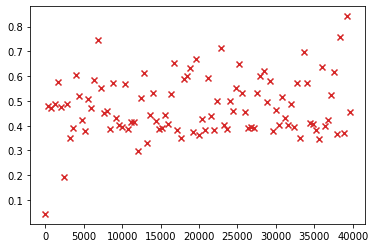

In [24]:
plt.scatter(range(0,40000,400), cr, c='tab:red', marker='x', label='DQN')

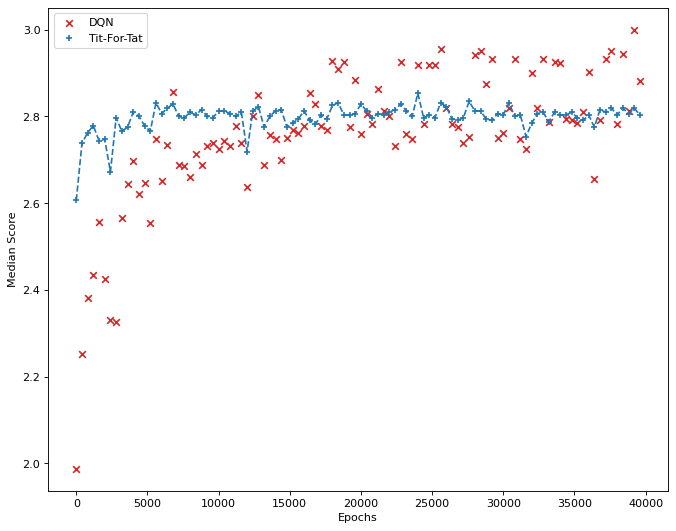

In [25]:
d_score = pd.DataFrame([l.loc['DQN','Median_score'] for l in ls]).to_numpy().T[0]
t_score = pd.DataFrame([l.loc['Tit For Tat','Median_score'] for l in ls]).to_numpy().T[0]

plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(0,40000,400), d_score, c='tab:red', marker='x', label='DQN')
plt.scatter(range(0,40000,400), t_score, c='tab:blue', marker='+', label='Tit-For-Tat')
#plt.plot(range(0,40000,400), d_score, c='tab:red')
plt.plot(range(0,40000,400), t_score, '--', c='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Median Score')
plt.legend(loc='upper left')
plt.show()

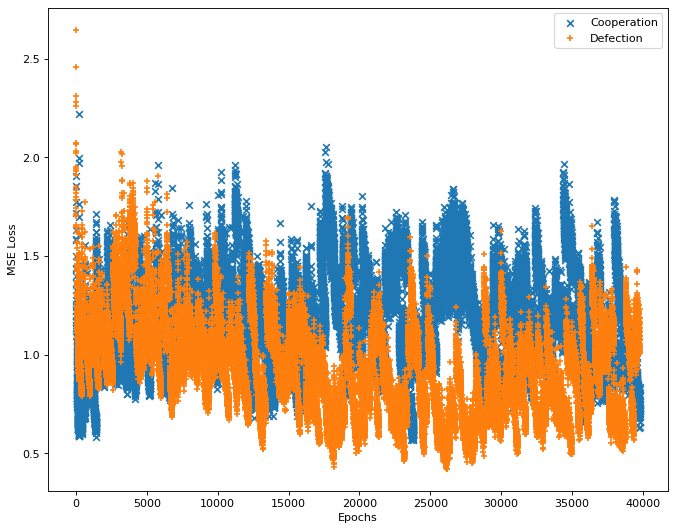

In [21]:
p1.plot()

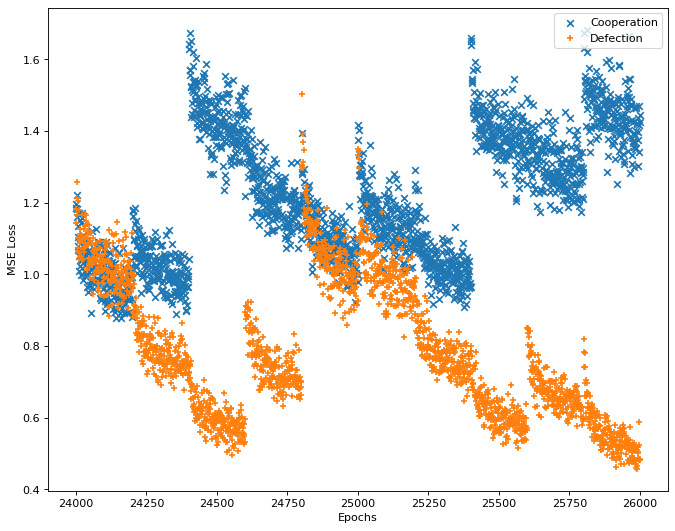

In [20]:
p1.plot(min_ran=24000,max_ran=26000)